In [3]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML

from typing import Tuple, List, Sequence, Optional, Union
from pathlib import Path
import re
import torch
import tokenizers as tk
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import transforms
from torch import nn, Tensor
from functools import partial
from bs4 import BeautifulSoup as bs
import warnings

from src.model import EncoderDecoder, ImgLinearBackbone, Encoder, Decoder
from src.utils import subsequent_mask, pred_token_within_range, greedy_sampling, bbox_str_to_token_list, cell_str_to_token_list, html_str_to_token_list, build_table_from_html_and_cell, html_table_template
from src.trainer.utils import VALID_HTML_TOKEN, VALID_BBOX_TOKEN, INVALID_CELL_TOKEN

warnings.filterwarnings('ignore')
# device = torch.device("cuda:0")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# # Check all model weights have been downloaded to experiments/unitable_weights
MODEL_FILE_NAME = ["unitable_large_structure.pt", "unitable_large_bbox.pt", "unitable_large_content.pt"]
MODEL_DIR = Path("experiments/unitable_weights")

# assert all([(MODEL_DIR / name).is_file() for name in MODEL_FILE_NAME]), f"Please download model weights from HuggingFace: https://huggingface.co/poloclub/UniTable/tree/main"

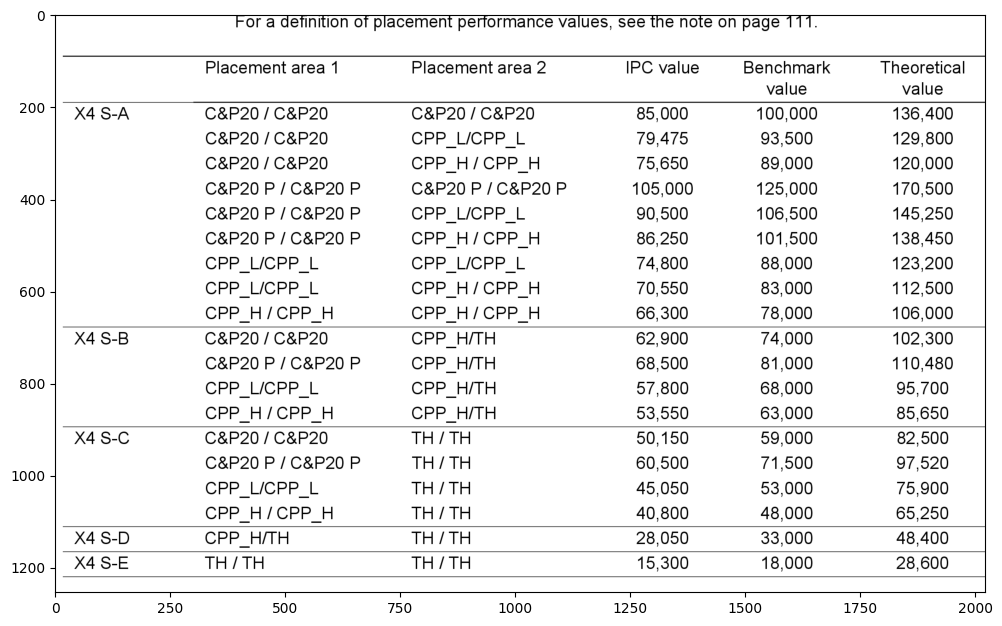

In [5]:
# Load tabular image
image_name = "page_1_table_0.png"
image_path = image_name
image = Image.open(image_path).convert("RGB")
image_size = image.size

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(image)

In [6]:
# UniTable large model
d_model = 768
patch_size = 16
nhead = 12
dropout = 0.2

backbone = ImgLinearBackbone(d_model=d_model, patch_size=patch_size)
encoder = Encoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=12,
    ff_ratio=4,
)
decoder = Decoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=4,
    ff_ratio=4,
)

In [7]:
def autoregressive_decode(
    model: EncoderDecoder,
    image: Tensor,
    prefix: Sequence[int],
    max_decode_len: int,
    eos_id: int,
    token_whitelist: Optional[Sequence[int]] = None,
    token_blacklist: Optional[Sequence[int]] = None,
) -> Tensor:
    model.eval()
    with torch.no_grad():
        memory = model.encode(image)
        context = torch.tensor(prefix, dtype=torch.int32).repeat(image.shape[0], 1) #.to(device)

    for _ in range(max_decode_len):
        eos_flag = [eos_id in k for k in context]
        if all(eos_flag):
            break

        with torch.no_grad():
            causal_mask = subsequent_mask(context.shape[1]) #.to(device)
            logits = model.decode(
                memory, context, tgt_mask=causal_mask, tgt_padding_mask=None
            )
            logits = model.generator(logits)[:, -1, :]

        logits = pred_token_within_range(
            logits.detach(),
            white_list=token_whitelist,
            black_list=token_blacklist,
        )

        next_probs, next_tokens = greedy_sampling(logits)
        context = torch.cat([context, next_tokens], dim=1)
    return context

def load_vocab_and_model(
    vocab_path: Union[str, Path],
    max_seq_len: int,
    model_weights: Union[str, Path],
) -> Tuple[tk.Tokenizer, EncoderDecoder]:
    vocab = tk.Tokenizer.from_file(vocab_path)
    model = EncoderDecoder(
        backbone=backbone,
        encoder=encoder,
        decoder=decoder,
        vocab_size=vocab.get_vocab_size(),
        d_model=d_model,
        padding_idx=vocab.token_to_id("<pad>"),
        max_seq_len=max_seq_len,
        dropout=dropout,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    )

    model.load_state_dict(torch.load(model_weights, map_location="cpu"))
    #model = model.to(device)
    return vocab, model

def image_to_tensor(image: Image, size: Tuple[int, int]) -> Tensor:
    T = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.86597056,0.88463002,0.87491087], std = [0.20686628,0.18201602,0.18485524])
    ])
    image_tensor = T(image)
    image_tensor = image_tensor.unsqueeze(0) #.to(device).unsqueeze(0)

    return image_tensor

def rescale_bbox(
    bbox: Sequence[Sequence[float]],
    src: Tuple[int, int],
    tgt: Tuple[int, int]
) -> Sequence[Sequence[float]]:
    assert len(src) == len(tgt) == 2
    ratio = [tgt[0] / src[0], tgt[1] / src[1]] * 2
    bbox = [[int(round(i * j)) for i, j in zip(entry, ratio)] for entry in bbox]
    return bbox

In [8]:
# Table structure extraction
vocab, model = load_vocab_and_model(
    vocab_path="vocab/vocab_html.json",
    max_seq_len=784,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[0],
)

# Image transformation
image_tensor = image_to_tensor(image, size=(448, 448))

# Inference
pred_html = autoregressive_decode(
    model=model,
    image=image_tensor,
    prefix=[vocab.token_to_id("[html]")],
    max_decode_len=512,
    eos_id=vocab.token_to_id("<eos>"),
    token_whitelist=[vocab.token_to_id(i) for i in VALID_HTML_TOKEN],
    token_blacklist = None
)

# Convert token id to token text
pred_html = pred_html.detach().cpu().numpy()[0]
pred_html = vocab.decode(pred_html, skip_special_tokens=False)
pred_html = html_str_to_token_list(pred_html)

# print(pred_html)

In [10]:
print(pred_html)
['<thead>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '</thead>', '<tbody>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '</tbody>']
len(pred_html) # 164
# Non-empty cell count: 105


['<thead>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '</thead>', '<tbody>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td></td>

164

In [11]:
# Table cell bbox detection
vocab, model = load_vocab_and_model(
    vocab_path="vocab/vocab_bbox.json",
    max_seq_len=1024,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[1],
)

# Image transformation
image_tensor = image_to_tensor(image, size=(448, 448))

# Inference
pred_bbox = autoregressive_decode(
    model=model,
    image=image_tensor,
    prefix=[vocab.token_to_id("[bbox]")],
    max_decode_len=1024,
    eos_id=vocab.token_to_id("<eos>"),
    token_whitelist=[vocab.token_to_id(i) for i in VALID_BBOX_TOKEN[: 449]],
    token_blacklist = None
)

# Convert token id to token text
pred_bbox = pred_bbox.detach().cpu().numpy()[0]
pred_bbox = vocab.decode(pred_bbox, skip_special_tokens=False)

# print(pred_bbox)

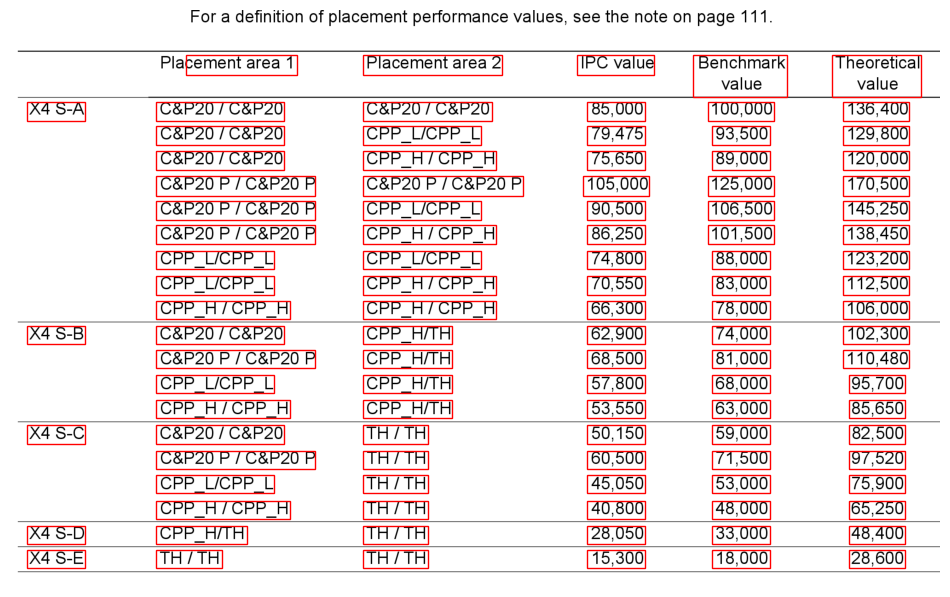

In [12]:
# Visualize detected bbox
pred_bbox = bbox_str_to_token_list(pred_bbox)
pred_bbox = rescale_bbox(pred_bbox, src=(448, 448), tgt=image_size)

fig, ax = plt.subplots(figsize=(12, 10))
for i in pred_bbox:
    rect = patches.Rectangle(i[:2], i[2] - i[0], i[3] - i[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.set_axis_off()
ax.imshow(image)

In [13]:
print(pred_bbox)
# [[383, 98, 623, 140], [767, 98, 1069, 140], [1232, 98, 1398, 140], [1484, 98, 1687, 188], [1786, 98, 1980, 188], [36, 199, 162, 241], [316, 199, 595, 241], [767, 199, 1047, 241], [1254, 199, 1380, 241], [1516, 199, 1660, 241], [1809, 199, 1953, 241], [316, 252, 595, 294], [767, 252, 1024, 294], [1254, 252, 1380, 294], [1525, 252, 1651, 294], [1809, 252, 1953, 294], [316, 305, 595, 347], [767, 305, 1056, 347], [1254, 305, 1380, 347], [1525, 305, 1651, 347], [1809, 305, 1953, 347], [316, 361, 663, 403], [767, 361, 1114, 403], [1245, 361, 1389, 403], [1516, 361, 1660, 403], [1809, 361, 1953, 403], [316, 414, 663, 456], [767, 414, 1024, 456], [1254, 414, 1380, 456], [1516, 414, 1660, 456], [1809, 414, 1953, 456], [316, 467, 663, 509], [767, 467, 1056, 509], [1254, 467, 1380, 509], [1516, 467, 1660, 509], [1809, 467, 1953, 509], [316, 523, 573, 563], [767, 523, 1024, 563], [1254, 523, 1380, 563], [1525, 523, 1651, 563], [1809, 523, 1953, 563], [316, 577, 573, 619], [767, 577, 1056, 619], [1254, 577, 1380, 619], [1525, 577, 1651, 619], [1809, 577, 1953, 619], [316, 633, 609, 672], [767, 633, 1056, 672], [1254, 633, 1380, 672], [1525, 633, 1651, 672], [1809, 633, 1953, 672], [36, 686, 162, 725], [316, 686, 595, 725], [767, 686, 961, 725], [1254, 686, 1380, 725], [1525, 686, 1651, 725], [1809, 686, 1953, 725], [316, 739, 663, 778], [767, 739, 961, 778], [1254, 739, 1380, 778], [1525, 739, 1651, 778], [1809, 739, 1953, 778], [316, 792, 573, 831], [767, 792, 961, 831], [1254, 792, 1380, 831], [1525, 792, 1651, 831], [1823, 792, 1944, 831], [316, 848, 609, 887], [767, 848, 961, 887], [1254, 848, 1380, 887], [1525, 848, 1651, 887], [1823, 848, 1944, 887], [36, 901, 162, 943], [316, 901, 595, 943], [767, 901, 907, 943], [1254, 901, 1380, 943], [1525, 901, 1651, 943], [1823, 901, 1944, 943], [316, 957, 663, 996], [767, 957, 907, 996], [1254, 957, 1380, 996], [1525, 957, 1651, 996], [1823, 957, 1944, 996], [316, 1010, 573, 1050], [767, 1010, 907, 1050], [1254, 1010, 1380, 1050], [1525, 1010, 1651, 1050], [1823, 1010, 1944, 1050], [316, 1066, 609, 1106], [767, 1066, 907, 1106], [1254, 1066, 1380, 1106], [1525, 1066, 1651, 1106], [1823, 1066, 1944, 1106], [36, 1120, 162, 1159], [316, 1120, 514, 1159], [767, 1120, 907, 1159], [1254, 1120, 1380, 1159], [1525, 1120, 1651, 1159], [1823, 1120, 1944, 1159], [36, 1173, 162, 1212], [316, 1173, 460, 1212], [767, 1173, 907, 1212], [1254, 1173, 1380, 1212], [1525, 1173, 1651, 1212], [1823, 1173, 1944, 1212]]

List[str]

len(pred_bbox) # 105

# 感覺沒有任何保證這個跟佔位符長度一致

[[383, 98, 623, 140], [767, 98, 1069, 140], [1232, 98, 1398, 140], [1484, 98, 1687, 188], [1786, 98, 1980, 188], [36, 199, 162, 241], [316, 199, 595, 241], [767, 199, 1047, 241], [1254, 199, 1380, 241], [1516, 199, 1660, 241], [1809, 199, 1953, 241], [316, 252, 595, 294], [767, 252, 1024, 294], [1254, 252, 1380, 294], [1525, 252, 1651, 294], [1809, 252, 1953, 294], [316, 305, 595, 347], [767, 305, 1056, 347], [1254, 305, 1380, 347], [1525, 305, 1651, 347], [1809, 305, 1953, 347], [316, 361, 663, 403], [767, 361, 1114, 403], [1245, 361, 1389, 403], [1516, 361, 1660, 403], [1809, 361, 1953, 403], [316, 414, 663, 456], [767, 414, 1024, 456], [1254, 414, 1380, 456], [1516, 414, 1660, 456], [1809, 414, 1953, 456], [316, 467, 663, 509], [767, 467, 1056, 509], [1254, 467, 1380, 509], [1516, 467, 1660, 509], [1809, 467, 1953, 509], [316, 523, 573, 563], [767, 523, 1024, 563], [1254, 523, 1380, 563], [1525, 523, 1651, 563], [1809, 523, 1953, 563], [316, 577, 573, 619], [767, 577, 1056, 619], [1

105

In [19]:
# Table cell content recognition
vocab, model = load_vocab_and_model(
    vocab_path="vocab/vocab_cell_6k.json",
    max_seq_len=200,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[2],
)

# Cell image cropping and transformation
image_tensor = [image_to_tensor(image.crop(bbox), size=(112, 448)) for bbox in pred_bbox]
image_tensor = torch.cat(image_tensor, dim=0)

# Inference
pred_cell = autoregressive_decode(
    model=model,
    image=image_tensor,
    prefix=[vocab.token_to_id("[cell]")],
    max_decode_len=200,
    eos_id=vocab.token_to_id("<eos>"),
    token_whitelist=None,
    token_blacklist = [vocab.token_to_id(i) for i in INVALID_CELL_TOKEN]
)

# Convert token id to token text
pred_cell = pred_cell.detach().cpu().numpy()
pred_cell = vocab.decode_batch(pred_cell, skip_special_tokens=False)
pred_cell = [cell_str_to_token_list(i) for i in pred_cell]
pred_cell = [re.sub(r'(\d).\s+(\d)', r'\1.\2', i) for i in pred_cell]

# print(pred_cell)

In [21]:
print(pred_cell)
# ['Main cellular process', 'Modulated pathways', 'P value', 'Genes in pathway', 'Expressed', 'total', '+ PMN', '- PMN', '+ PMN', 'PMN', 'Cell cycle', 'Role of APC in cell cycle regulation', '1.040E - 09', '8.149E - 08', '15', '12', '32', 'Chromosome condensation in prometaphase', '4.131E - 06', '8.392E - 11', '9', '12', '20', 'The metaphase checkpoint', '4.423E - 06', '1.474E - 04', '12', '9', '36', 'Spindle assembly and chromosome separation', '3.170E - 04', '1.937E - 03', '9', '7', '32', 'Start of DNA replication in early S phase', '1.284E - 03', '3.115E - 02', '8', '5', '31', 'Initiation of mitosis', '1.544E - 03', '2.483E - 03', '7', '6', '25', 'Sister chromatid cohesion', '1.530E - 02', '5', '21', 'Transition and termination of DNA replication', '1.523E - 02', '5', '26', 'Role of Nek in cell cycle regulation', '2.390E - 02', '5', '29', 'Nucleocytoplasmic transport of CDK / Cyclins', '4.386E - 02', '3', '14', 'Immune response', 'Alternative complement pathway', '4.539E - 07', '2.737E - 02', '12', '5', '30', 'Fc gamma R - mediated phagocytosis', '1.606E - 03', '9.058E - 03', '8', '6', '32', 'Antigen presentation by MHC class II', '6.046E - 03', '2.644E - 03', '4', '4', '11', 'Classic complement pathway', '1.517E - 05', '12', '40', 'Antiviral actions of Interferons', '2.431E - 04', '9', '31', 'CCR3 signalling', '8.728E - 04', '12', '59', 'Lectin Induced complement pathway', '1.251E - 03', '9', '38', 'Lipoxin inhibitory action on Superoxide production', '1.544E - 03', '2.483E - 03', '7', '6', '25', 'IFN alpha / beta signalling pathway', '6.214E - 03', '6', '24', 'IL - 10 signalling pathway', '2.245E - 02', '5', '23', 'Antigen presentation by MHC class I', '3.675E - 02', '5', '26', 'Transcription regulation of granulocyte development', '3.115E - 02', '5', '31', 'Oxidative stress', 'ROS production', '8.932E - 04', '4.113E - 02', '7', '4', '23', 'Apoptosis', 'Inhibition of ROS induced apoptosis', '3.675E - 02', '5', '26', 'G protein signalling', 'Rac2 regulation pathway', '4.957E - 03', '4.113E - 02', '6', '4', '23', 'RAC1 in cellular process', '1.361E - 02', '6', '28', 'Cytoskeleton remodelling', 'Regulation of actin cytoskeleton by Rho GTPases', '8.972E - 03', '5', '23', 'Alpha - 1A adrenergic receptor - dependent inhibition of PI3K', '2.887E - 02', '3', '12', 'Metabolic process', 'Lipoprotein metabolism I. Chylomicron, VLDL and LDL metabolism', '1.630E - 02', '9.007E - 07', '3', '6', '8', 'Lipoprotein metabolism II. HDL metabolism', '1.630E - 02', '9.007E - 07', '3', '6', '8', 'G - alpha ( q ) regulation of lipid metabolism', '2.245E - 02', '5', '23', 'Urea cycle', '3.675E - 02', '5', '26', 'LDL metabolism during development of fatty streak lesion', '1.870E - 02', '2', '4']

List[str]

len(pred_cell) # 177

['Main cellular process', 'Modulated pathways', 'P value', 'Genes in pathway', 'Expressed', 'total', '+ PMN', '- PMN', '+ PMN', 'PMN', 'Cell cycle', 'Role of APC in cell cycle regulation', '1.040E - 09', '8.149E - 08', '15', '12', '32', 'Chromosome condensation in prometaphase', '4.131E - 06', '8.392E - 11', '9', '12', '20', 'The metaphase checkpoint', '4.423E - 06', '1.474E - 04', '12', '9', '36', 'Spindle assembly and chromosome separation', '3.170E - 04', '1.937E - 03', '9', '7', '32', 'Start of DNA replication in early S phase', '1.284E - 03', '3.115E - 02', '8', '5', '31', 'Initiation of mitosis', '1.544E - 03', '2.483E - 03', '7', '6', '25', 'Sister chromatid cohesion', '1.530E - 02', '5', '21', 'Transition and termination of DNA replication', '1.523E - 02', '5', '26', 'Role of Nek in cell cycle regulation', '2.390E - 02', '5', '29', 'Nucleocytoplasmic transport of CDK / Cyclins', '4.386E - 02', '3', '14', 'Immune response', 'Alternative complement pathway', '4.539E - 07', '2.737

177

In [27]:
# Combine the table structure and cell content
pred_code = build_table_from_html_and_cell(pred_html, pred_cell)
pred_code = "".join(pred_code)
pred_code = html_table_template(pred_code)

print(pred_code)

<html>
        <head> <meta charset="UTF-8">
        <style>
        table, th, td {
            border: 1px solid black;
            font-size: 10px;
        }
        </style> </head>
        <body>
        <table frame="hsides" rules="groups" width="100%%">
            <thead><tr><td  colspan="2"<td  colspan="3"</tr><tr><td></td><td></td><td></td><td></td><td  colspan="2"</tr><tr><td></td><td></td><td></td></tr></thead><tbody><tr></tr><tr><td></td></tr><tr><td></td></tr><tr><td></td></tr><tr><td></td></tr><tr><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td></tr><tr></tr><tr><td></td></tr><tr><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td></td><td></td><td></td></tr><tr><td><

In [25]:
# Combine the table structure and cell content
pred_code = build_table_from_html_and_cell(pred_html, pred_cell)
pred_code = "".join(pred_code)
pred_code = html_table_template(pred_code)

# Display the HTML table
soup = bs(pred_code)
table_code = soup.prettify()
display(HTML(table_code))

In [11]:
# Raw HTML table code
print(table_code)

<html>
 <head>
  <meta charset="utf-8"/>
  <style>
   table, th, td {
            border: 1px solid black;
            font-size: 10px;
        }
  </style>
 </head>
 <body>
  <table frame="hsides" rules="groups" width="100%%">
   <thead>
    <tr>
     <td>
      Main cellular process
     </td>
     <td>
      Modulated pathways
     </td>
     <td colspan="2">
      P value
     </td>
     <td colspan="3">
      Genes in pathway
     </td>
    </tr>
    <tr>
     <td>
     </td>
     <td>
     </td>
     <td>
     </td>
     <td>
     </td>
     <td colspan="2">
      Expressed
     </td>
     <td>
      total
     </td>
    </tr>
    <tr>
     <td>
     </td>
     <td>
     </td>
     <td>
      + PMN
     </td>
     <td>
      - PMN
     </td>
     <td>
      + PMN
     </td>
     <td>
      PMN
     </td>
     <td>
     </td>
    </tr>
   </thead>
   <tbody>
    <tr>
     <td>
      Cell cycle
     </td>
     <td>
      Role of APC in cell cycle regulation
     </td>
     <td>
   

## Evaluation - Proceed only if you have the groundtruth annotation.

In [12]:
from src.utils.teds import TEDS
import jsonlines
from src.vocab.constant import CELL_SPECIAL

In [13]:
# Load groundtruth annotation
annotation_path = "../dataset/mini_pubtabnet/mini_pubtabnet_examples.jsonl"
with jsonlines.open(annotation_path) as f:
    for obj in f:
        if obj["filename"] == image_name:
            anno_html_raw = obj["html"]["structure"]["tokens"]
            anno_cell_raw = ["".join(cell["tokens"]) for cell in obj["html"]["cells"] if cell["tokens"]]
            break

anno_html = []
idx = 0
while idx < len(anno_html_raw):
    if "[" in anno_html_raw[idx]:
        assert idx + 1 < len(anno_html_raw)
        assert anno_html_raw[idx + 1] == "]</td>"
        anno_html.append(anno_html_raw[idx] + "]</td>")
        idx = idx + 2
    else:
        anno_html.append(anno_html_raw[idx])
        idx = idx + 1

anno_cell = []
for txt in anno_cell_raw:
    for black in CELL_SPECIAL:
        txt = txt.replace(black, "")
    anno_cell.append(txt)

anno_code = "".join(build_table_from_html_and_cell(anno_html, anno_cell))

In [14]:
# Evaluate table structure only (S-TEDS)
teds = TEDS(structure_only=True)
teds.evaluate(pred_code, html_table_template(anno_code))

1.0

In [15]:
# Evaluate both table structure and cell content (TEDS)
teds = TEDS(structure_only=False)
teds.evaluate(pred_code, html_table_template(anno_code))

0.9523398767490218